# Loading the data and adding noise to it
---
- We use the MNIST dataset and add a Gaussian noise with a mean of 0 and a standard deviation of 0.3 to create the noisy dataset.

In [6]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.5):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        noisy = tensor + torch.randn(tensor.size()) * self.std + self.mean
        return torch.clip(noisy, 0., 1.)


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

1.0
0.0


# Concatenating the noisy and original dataset
---

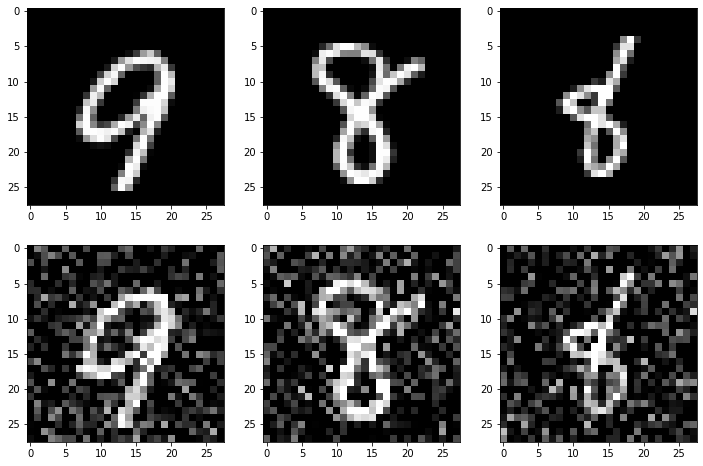

In [7]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

_, (noisy, original) = next(enumerate(train_loader))

fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(original[idx][0], cmap='gray')
  ax[1,idx].imshow(noisy[idx][0], cmap='gray')
fig.show()

# Creating the denoising autoencoder model
---

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

class DenoisingAutoEncoder(nn.Module):
  def __init__(self):
    super(DenoisingAutoEncoder, self).__init__()


    ########################################
    # Encoder layers
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3,padding=1)
    self.pool = nn.MaxPool2d(2, 2)

   #########################################
    # Decoder layers
    self.de_conv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
    self.de_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

   ##########################################

  def forward(self, x):

    # encoding layers
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    ## decoding layers
    x = F.relu(self.de_conv1(x))
    x = F.sigmoid(self.de_conv2(x))   

    return x

In [12]:
# Initializing the model and setting the initial hyperparameters
AE = DenoisingAutoEncoder().to(device)
optimizer = optim.Adam(AE.parameters(), lr=0.001)
loss_fn = nn.MSELoss(reduction='sum')

# Training the model on the data
---

In [13]:
def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (images, _) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = images.to(device)
    output = AE(images)
    loss = loss_fn(output, images) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.to(device)
      output = AE(images)
      test_loss += loss_fn(output, images).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}\n')


train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 10

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1: [0/60000] Loss: 131.3927459716797
Epoch 1: [6400/60000] Loss: 46.08645248413086
Epoch 1: [12800/60000] Loss: 34.68865203857422
Epoch 1: [19200/60000] Loss: 31.8262882232666
Epoch 1: [25600/60000] Loss: 28.507667541503906
Epoch 1: [32000/60000] Loss: 27.71334457397461
Epoch 1: [38400/60000] Loss: 26.40777587890625
Epoch 1: [44800/60000] Loss: 25.777515411376953
Epoch 1: [51200/60000] Loss: 25.9100284576416
Epoch 1: [57600/60000] Loss: 24.813804626464844
Test result on epoch 1: Avg loss is 24.658129296875

Epoch 2: [0/60000] Loss: 24.38459014892578
Epoch 2: [6400/60000] Loss: 23.75595474243164
Epoch 2: [12800/60000] Loss: 23.390226364135742
Epoch 2: [19200/60000] Loss: 22.92270278930664
Epoch 2: [25600/60000] Loss: 22.17607879638672
Epoch 2: [32000/60000] Loss: 22.150787353515625
Epoch 2: [38400/60000] Loss: 22.110971450805664
Epoch 2: [44800/60000] Loss: 22.111711502075195
Epoch 2: [51200/60000] Loss: 21.817209243774414
Epoch 2: [57600/60000] Loss: 21.383953094482422
Test resul

# Plotting the results
---

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])


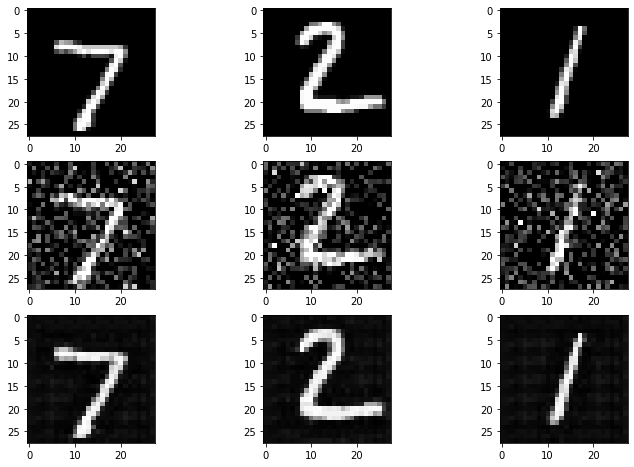

In [14]:
batch_idx, (noisy, images) = next(enumerate(test_loader))
images = images.to(device)
output = AE(images).cpu().detach()
images = images.cpu()

print(images.size(), output.size())

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,8)

for idx in range(3):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[1,idx].imshow(noisy[idx][0], cmap='gray')
  ax[2,idx].imshow(output[idx][0], cmap='gray')
fig.show()